In [55]:
import pandas as pd
import re
import numpy as np
from unidecode import unidecode
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


In [56]:
df = pd.read_csv("momo_reviews_update12_07.csv")
df.head(5)

,Tên phim,Người đánh giá,Điểm,Nhãn cảm xúc,Nội dung đánh giá,Tags cảm xúc
0,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Đỗ Trần Bảo Ngọc,5/10,· Tạm ổn,Yêu thích phim kinh dị nên đi coi. Phim coi nh...,NaN
1,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Nguyen Thi Mui,6/10,· Tạm ổn,thật sự ai có í định xem thì dừn glahi phim dở...,NaN
2,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Lê Phương Thảo,5/10,· Tạm ổn,"mình thấy phim ok, cốt truyện cũng khá là ổn, ...",NaN
3,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Nguyễn Vân Trang,3/10,· Chưa ưng lắm,mãi mới có phim kinh dị hay như vậy đó mọi ngư...,NaN
4,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,NGUYEN THUY VAN,6/10,· Tạm ổn,"Mình nghe về truyền thuyết này từ lâu, nay mới...",NaN


In [57]:
print("so dong", len(df))

df = df.dropna(subset=["Nội dung đánh giá"])

df = df.drop_duplicates()

print("so dong sau khi drop", len(df))


so dong 84208
so dong sau khi drop 69728


In [58]:
# Làm sạch cột "Nhãn cảm xúc" - bỏ dấu chấm và khoảng trắng đầu
df["Nhãn cảm xúc"] = df["Nhãn cảm xúc"].str.strip().str.lstrip("·. ").str.strip()

# Kiểm tra sau làm sạch
print(df["Nhãn cảm xúc"].unique())

['Tạm ổn' 'Chưa ưng lắm' 'Cực phẩm!' 'Đáng xem' 'Kén người mê' nan]


In [59]:

df = df.dropna(subset=["Nhãn cảm xúc"])  # bỏ nếu là NaN
df = df[df["Nhãn cảm xúc"].str.strip() != ""]  # bỏ nếu là chuỗi trắng

# Kiểm tra số dòng còn lại
print("Số dòng còn lại sau khi xóa nhãn rỗng:", len(df))

Số dòng còn lại sau khi xóa nhãn rỗng: 57910


In [60]:
teencode_dict = {
    "siu": "siêu", "iu": "yêu", "thik": "thích", "thíchk": "thích", "hok": "không", "k": "không",
    "ko": "không", "khum": "không", "cx": "cũng", "mik": "mình", "mk": "mình", "ms": "mới",
    "cmt": "bình luận", "z": "rồi", "jk": "giỡn", "vl": "vãi", "vcl": "vãi",
    "okie": "ok", "oke": "ok", "bt": "bình thường", "dc": "được", "dcmm": "được",
    "wa": "qua", "wao": "qua", "wá": "qua", "qa": "qua", "quae": "qua", "quee": "qua"
}




In [61]:
# Định nghĩa nguyên âm/phụ âm tiếng Việt
VIETNAMESE_CONSONANTS = "bcdfghjklmnpqrstvwxzđy"
VIETNAMESE_VOWELS = "aáàảãạăắằẳẵặâấầẩẫậeéèẻẽẹêếềểễệiíìỉĩịoóòỏõọôốồổỗộơớờởỡợuúùủũụưứừửữựyýỳỷỹỵ"

def is_gibberish_advanced(word, max_consonants=5, max_vowels=5):
    if len(word) > 9:
        return True

    consonant_count = 0
    vowel_count = 0

    for char in word:
        if char in VIETNAMESE_CONSONANTS:
            consonant_count += 1
            vowel_count = 0
        elif char in VIETNAMESE_VOWELS:
            vowel_count += 1
            consonant_count = 0
        else:
            consonant_count = 0
            vowel_count = 0

        if consonant_count > max_consonants or vowel_count > max_vowels:
            return True

    if all(c not in VIETNAMESE_VOWELS for c in word):
        return True
    if all(c not in VIETNAMESE_CONSONANTS for c in word):
        return True

    return False

In [62]:
def clean_review_no_accent(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = unidecode(text)

    text = re.sub(r"[^\w\s]", " ", text)
    words = text.strip().split()
    cleaned_words = []

    for word in words:
        word = re.sub(r"(.)\1{2,}", r"\1\1", word)  # giảm lặp ký tự
        word = teencode_dict.get(word, word)
        if is_gibberish_advanced(word):            # loại từ vô nghĩa
            continue
        if len(word) > 1 or word in {"a", "o"}:
            cleaned_words.append(word)

    if len(cleaned_words) < 3:
        return ""

    return " ".join(cleaned_words)


In [63]:
def clean_review_with_accent(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    text = re.sub(r"[^\w\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]", " ", text)

    words = text.strip().split()
    cleaned_words = []

    for word in words:
        word = re.sub(r"(.)\1{2,}", r"\1", word) # giảm lặp ký tự
        word = teencode_dict.get(word, word)
        if is_gibberish_advanced(word):            # loại từ vô nghĩa
            continue
        if len(word) > 1 or word in {'a', 'o'}:
            cleaned_words.append(word)

    if len(cleaned_words) < 3:
        return ""

    return " ".join(cleaned_words)


In [64]:
# Áp dụng hàm làm sạch không dấu
df["Noi_dung_sach"] = df["Nội dung đánh giá"].apply(clean_review_no_accent)

# Áp dụng hàm làm sạch giữ dấu
df["Noi_dung_sach_giu_dau"] = df["Nội dung đánh giá"].apply(clean_review_with_accent)

# Kiểm tra số dòng còn lại sau làm sạch
print("Sau khi làm sạch văn bản:", len(df))


Sau khi làm sạch văn bản: 57910


In [65]:
# Xoá dòng trống sau xử lí
df = df[df["Noi_dung_sach"].str.strip() != ""]
df = df[df["Noi_dung_sach_giu_dau"].str.strip() != ""]

# Kiểm tra lần cuối
print("Sau khi loại dòng rỗng:", len(df))

Sau khi loại dòng rỗng: 51824


In [66]:
# # hàm gắn nhãn cảm xúc dựa trên nội dung văn bản
# def map_emotion(Label):
#     if Label in ["Cực phẩm!", "Đáng xem"]:
#         return "Tích cực"
#     elif Label == "Tạm ổn":
#         return "Trung lập"
#     elif Label in ["Chưa ưng lắm", "Kén người mê"]:
#         return "Tiêu cực"
#     else:
#         return "Không xác định"  # mặc định nếu không khớp

# # Tạo cột mới: "Nhãn cảm xúc"
# df_labeled["label"] = df_labeled["Nhãn cảm xúc"].apply(map_emotion)

# # Xem tần suất của các nhãn
# print(df_labeled["label"].value_counts())

In [67]:
# Hàm chuyển đổi điểm từ dạng chuỗi "x/10" sang số nguyên
def get_score(rating_str):
    try:
        # Xử lý trường hợp "x/10"
        if isinstance(rating_str, str) and '/10' in rating_str:
            return int(rating_str.split('/')[0])
    except (ValueError, IndexError):
        # Trả về NaN nếu định dạng không hợp lệ
        return np.nan
    return np.nan

In [68]:
df['score'] = df['Điểm'].apply(get_score)
df.dropna(subset=['score'], inplace=True) # Xóa các dòng không thể lấy điểm
df['score'] = df['score'].astype(int)


In [69]:
def score_to_label(score):
    if score <= 4:
        return 'Tiêu cực'
    elif 5 <= score <= 7:
        return 'Trung lập'
    else: # score >= 8
        return 'Tích cực'

df['Nhãn'] = df['score'].apply(score_to_label)

print(df["Nhãn"].value_counts())

df.head()

Nhãn
Tích cực     35936
Tiêu cực      9234
Trung lập     6654
Name: count, dtype: int64


,Tên phim,Người đánh giá,Điểm,Nhãn cảm xúc,Nội dung đánh giá,Tags cảm xúc,Noi_dung_sach,Noi_dung_sach_giu_dau,score,Nhãn
0,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Đỗ Trần Bảo Ngọc,5/10,Tạm ổn,Yêu thích phim kinh dị nên đi coi. Phim coi nh...,NaN,yeu thich phim kinh di nen di coi phim coi nhu...,yêu thích phim kinh dị nên đi coi phim coi như...,5,Trung lập
1,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Nguyen Thi Mui,6/10,Tạm ổn,thật sự ai có í định xem thì dừn glahi phim dở...,NaN,that su co dinh xem thi dun glahi phim do cuc ...,thật sự có định xem thì dừn glahi phim dở cực ...,6,Trung lập
2,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Lê Phương Thảo,5/10,Tạm ổn,"mình thấy phim ok, cốt truyện cũng khá là ổn, ...",NaN,minh thay phim ok cot truyen cung kha la on kh...,mình thấy phim ok cốt truyện cũng khá là ổn kh...,5,Trung lập
3,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,Nguyễn Vân Trang,3/10,Chưa ưng lắm,mãi mới có phim kinh dị hay như vậy đó mọi ngư...,NaN,mai moi co phim kinh di hay nhu vay do moi ngu...,mãi mới có phim kinh dị hay như vậy đó mọi ngư...,3,Tiêu cực
4,Review phim Kisaragi: Nhà Ga Nuốt Chửng trên MoMo,NGUYEN THUY VAN,6/10,Tạm ổn,"Mình nghe về truyền thuyết này từ lâu, nay mới...",NaN,minh nghe ve truyen thuyet nay tu lau nay moi ...,mình nghe về truyền thuyết này từ lâu nay mới ...,6,Trung lập


In [70]:
##### DROP cac cot khong can thiet ###

df.drop('score', axis=1, inplace=True)
df.drop('Nhãn cảm xúc', axis=1, inplace=True)
df.drop('Tên phim', axis=1, inplace=True)
df.drop('Người đánh giá', axis=1, inplace=True)
df.drop('Điểm', axis=1, inplace=True)


In [71]:
df.head()

,Nội dung đánh giá,Tags cảm xúc,Noi_dung_sach,Noi_dung_sach_giu_dau,Nhãn
0,Yêu thích phim kinh dị nên đi coi. Phim coi nh...,NaN,yeu thich phim kinh di nen di coi phim coi nhu...,yêu thích phim kinh dị nên đi coi phim coi như...,Trung lập
1,thật sự ai có í định xem thì dừn glahi phim dở...,NaN,that su co dinh xem thi dun glahi phim do cuc ...,thật sự có định xem thì dừn glahi phim dở cực ...,Trung lập
2,"mình thấy phim ok, cốt truyện cũng khá là ổn, ...",NaN,minh thay phim ok cot truyen cung kha la on kh...,mình thấy phim ok cốt truyện cũng khá là ổn kh...,Trung lập
3,mãi mới có phim kinh dị hay như vậy đó mọi ngư...,NaN,mai moi co phim kinh di hay nhu vay do moi ngu...,mãi mới có phim kinh dị hay như vậy đó mọi ngư...,Tiêu cực
4,"Mình nghe về truyền thuyết này từ lâu, nay mới...",NaN,minh nghe ve truyen thuyet nay tu lau nay moi ...,mình nghe về truyền thuyết này từ lâu nay mới ...,Trung lập


### Visualize


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

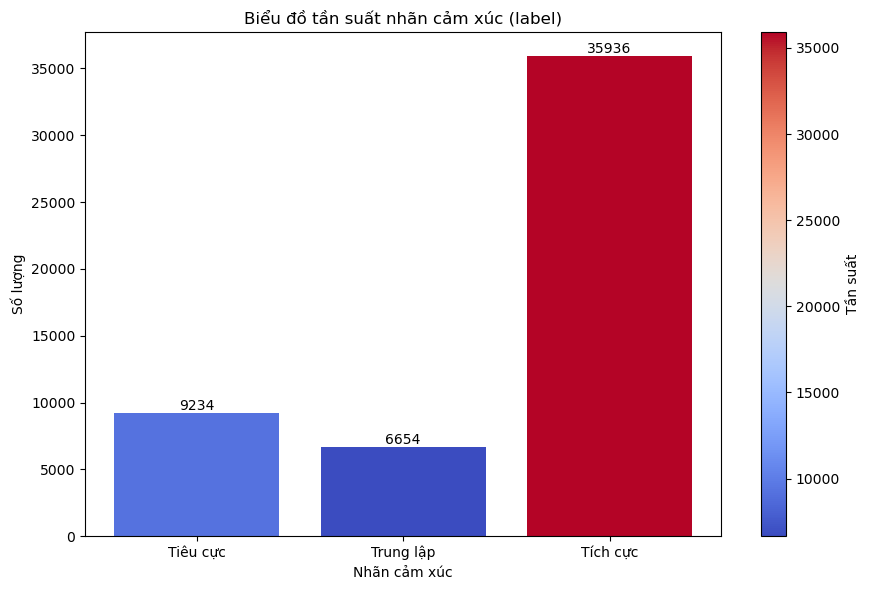

In [73]:
# Đếm số lượng mỗi nhãn cảm xúc từ cột 'label'
label_counts = df['Nhãn'].value_counts().sort_index()  # sort theo nhãn tăng dần
labels = label_counts.index
values = label_counts.values

# Tạo màu theo tần suất
norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
cmap = plt.get_cmap('coolwarm')
colors = [cmap(norm(v)) for v in values]

# Vẽ biểu đồ cột
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.bar(labels, values, color=colors)

# Hiển thị số lượng trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

# Thêm thanh màu (colorbar)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Tần suất")

# Thêm tiêu đề và nhãn trục
ax.set_title("Biểu đồ tần suất nhãn cảm xúc (label)")
ax.set_xlabel("Nhãn cảm xúc")
ax.set_ylabel("Số lượng")

plt.tight_layout()
plt.show()

In [77]:
from sklearn.utils import resample

# Phân tách các lớp nhãn
df_positive = df[df["Nhãn"] == "Tích cực"]
df_negative = df[df["Nhãn"] == "Tiêu cực"]
df_neutral  = df[df["Nhãn"] == "Trung lập"]

# Lấy số lượng lớn nhất trong các lớp
max_count = max(len(df_positive), len(df_negative), len(df_neutral))

# Oversampling các lớp nhỏ hơn
df_positive_upsampled = resample(df_positive, replace=True, n_samples=max_count, random_state=42)
df_negative_upsampled = resample(df_negative, replace=True, n_samples=max_count, random_state=42)
df_neutral_upsampled  = resample(df_neutral,  replace=True, n_samples=max_count, random_state=42)

# Gộp lại và shuffle
df = pd.concat([df_positive_upsampled, df_negative_upsampled, df_neutral_upsampled])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# In ra kiểm tra số lượng từng nhãn
print(df["Nhãn"].value_counts())

df.to_csv("momo_review_clean_balanced.csv", index= False)

Nhãn
Tiêu cực     35936
Tích cực     35936
Trung lập    35936
Name: count, dtype: int64


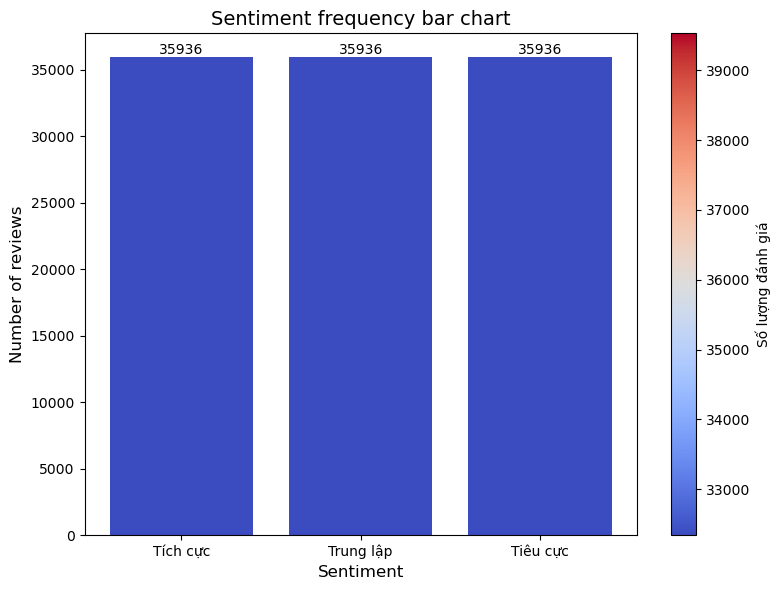

In [75]:
# Xác định thứ tự nhãn cảm xúc nếu cần
label_order = ['Tích cực', 'Trung lập', 'Tiêu cực']  # Đặt đúng thứ tự bạn muốn hiển thị

# Đếm số lượng từng loại cảm xúc (nếu nhãn là dạng chuỗi)
sentiment_counts = df['Nhãn'].value_counts().reindex(label_order).fillna(0)
labels = sentiment_counts.index.tolist()
values = sentiment_counts.values

# Ánh xạ màu theo giá trị
norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
cmap = plt.get_cmap('coolwarm')
colors = [cmap(norm(v)) for v in values]

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, values, color=colors)

# Thêm colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Số lượng đánh giá")

# Gắn tiêu đề và nhãn trục
ax.set_title("Sentiment frequency bar chart", fontsize=14)
ax.set_xlabel("Sentiment", fontsize=12)
ax.set_ylabel("Number of reviews", fontsize=12)

# Hiển thị số trên cột
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{int(height)}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
